# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

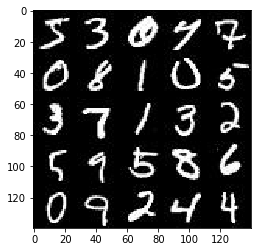

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

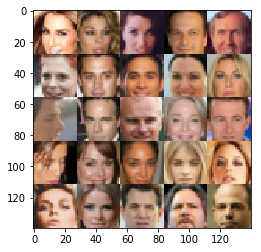

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels),
                                  name='inputs_real')
    inputs_z = tf.placeholder(tf.float32,
                              (None, z_dim),
                              name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha*x1, x1)
        #14
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        #7
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
                
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        stddev = 0.02
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #14
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev) )
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #28
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake                            
                            
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    size = data_shape[1]
    dim = 3 if data_image_mode=="RGB" else 1
       
    input_real, input_z, var_learning_rate = model_inputs(size, size, dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, var_learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                                
                images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    input_real: images,
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                   })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                })
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.2682
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.8866


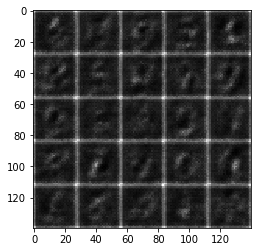

Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 1.6231
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 1.2945
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 1.1042
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 1.1931


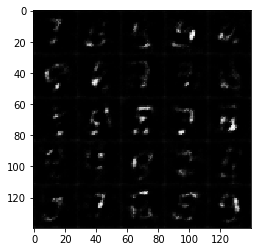

Epoch 1/2... Discriminator Loss: 1.0892... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.6365
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.3421


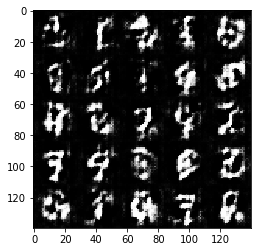

Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 1.1918
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 0.9883
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 1.2928
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.2520
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 1.0942
Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 1.3142
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.7503


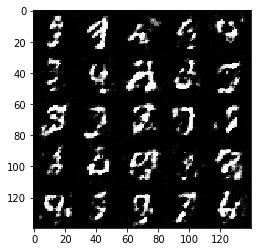

Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 1.4632
Epoch 1/2... Discriminator Loss: 0.9463... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 1.3309
Epoch 1/2... Discriminator Loss: 0.9132... Generator Loss: 1.2416
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.3287
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.3450
Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 1.1868
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 0.9216... Generator Loss: 1.0576


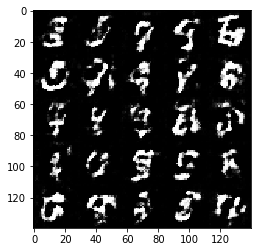

Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 1.5386
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 0.8650... Generator Loss: 1.2722
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 1.3345
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.7589
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 0.9019
Epoch 1/2... Discriminator Loss: 0.8883... Generator Loss: 1.1607
Epoch 1/2... Discriminator Loss: 0.8304... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.4274


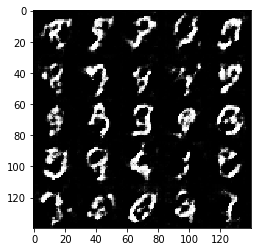

Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.5347
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 1.7200
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 1.3514
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.1954
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.0484
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 1.2637


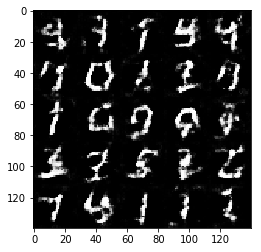

Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 1.1635
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 1.2863
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 1.4671
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 1.3865
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.9064
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.8092


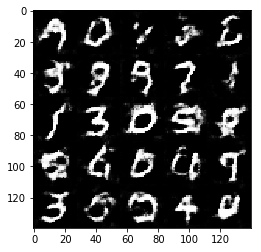

Epoch 1/2... Discriminator Loss: 0.9132... Generator Loss: 1.5338
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.1414
Epoch 1/2... Discriminator Loss: 1.0344... Generator Loss: 1.5425
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 1.2255
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 1.2159
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 1.2232
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.1637


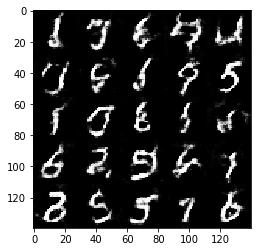

Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 1.0610
Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 1.1501
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.2217
Epoch 2/2... Discriminator Loss: 0.9652... Generator Loss: 1.3390
Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 1.0307
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 1.1029


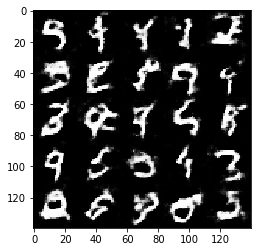

Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 1.2167
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 1.3287
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 1.0325
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.5882
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.2134
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.1716
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 1.2690
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 1.1110


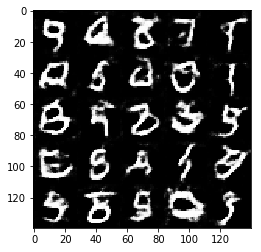

Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 1.5611
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.6473
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.4137
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.1751
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 0.9385
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 1.0496
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.0105
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 1.3363


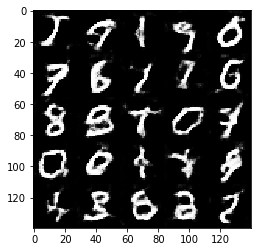

Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.0824
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 1.5450
Epoch 2/2... Discriminator Loss: 1.0437... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.9311
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 1.2161
Epoch 2/2... Discriminator Loss: 1.0614... Generator Loss: 1.3441
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.9576
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.9294
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.5904
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 1.2822


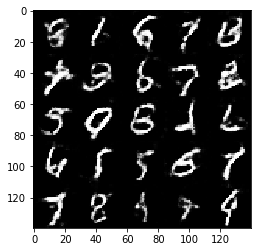

Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 1.0394
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 1.1522
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 1.2267
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.0837
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 1.4298
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 0.9622


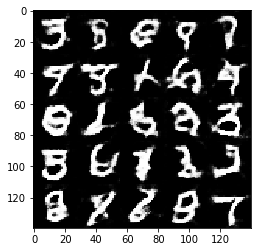

Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.9341
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.4206
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 1.2341
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.9026
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 1.1059
Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 1.1679


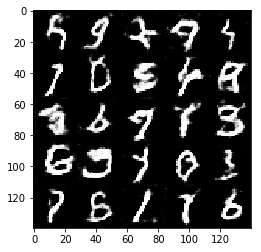

Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.1158
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 1.2495
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 1.1744


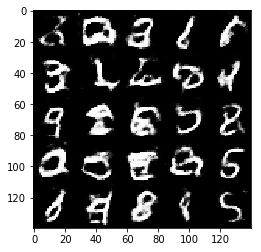

Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 1.0241
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 1.2797
Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 0.9906
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 1.3273
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 1.5025
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 0.9315
Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.0471


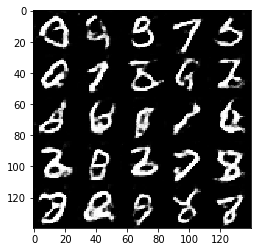

Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 1.1142
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 1.3701
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.5507
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.4745
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 0.9912
Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 1.6596
Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 1.0216


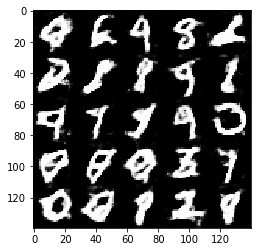

Epoch 2/2... Discriminator Loss: 1.0347... Generator Loss: 1.1721
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 1.2166
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.1938
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.3047
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.3991


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2246... Generator Loss: 0.2202
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.3354
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.8831


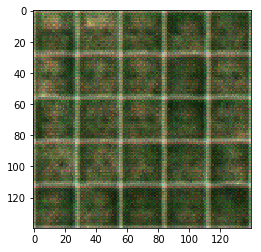

Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.5502
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8629


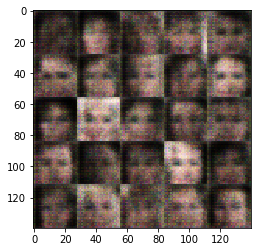

Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.2288
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.5374
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.9994


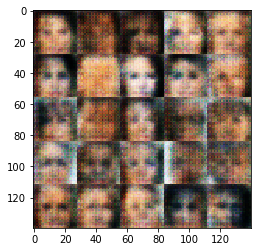

Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.5540
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.0481


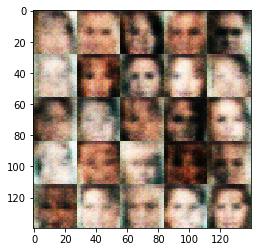

Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.3897
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 1.0761


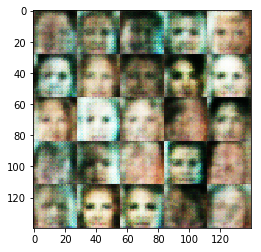

Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9811


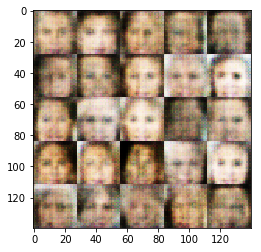

Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.2194
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9084


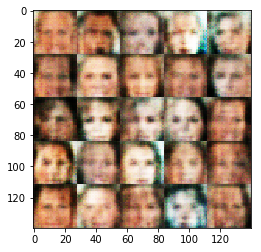

Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6499


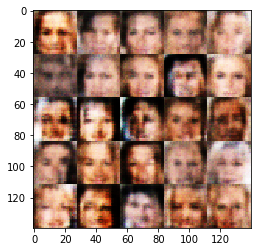

Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.6174... Generator Loss: 2.9652
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8900


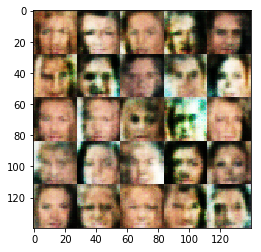

Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.7815


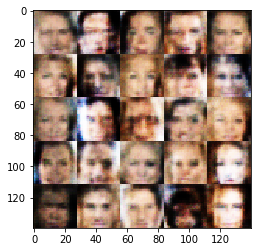

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8522


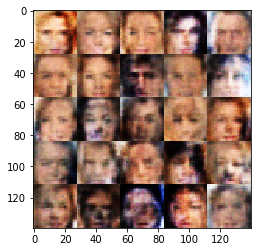

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7287


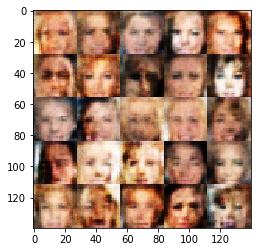

Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.1720
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6113


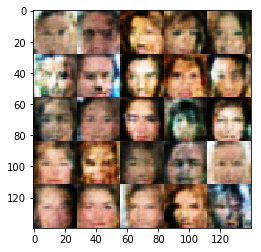

Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.9495


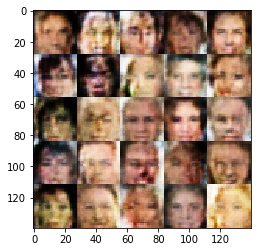

Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.8297


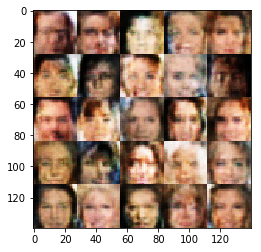

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8583


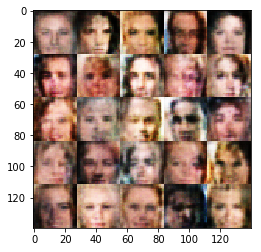

Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8744


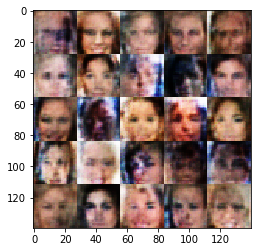

Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8003


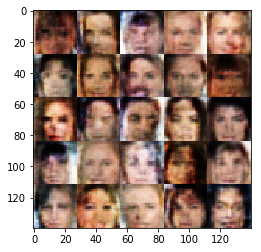

Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.7281


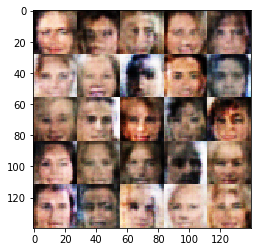

Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6412


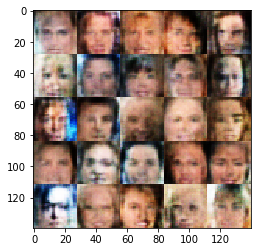

Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.9742


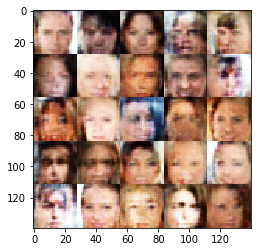

Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.9816


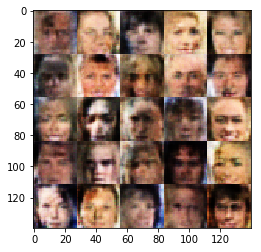

Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.9413


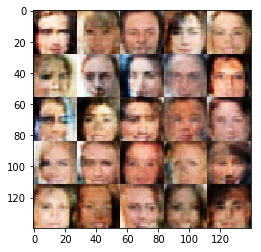

Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.0649


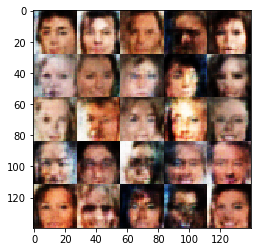

Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.5457


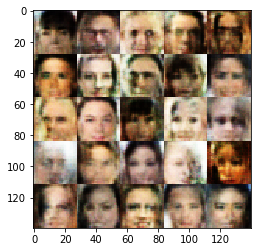

Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 2.1113
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.5261


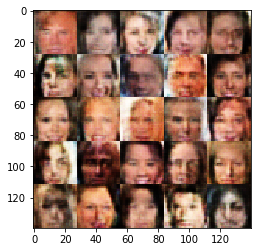

Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.4570
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5516


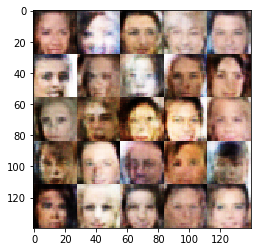

Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.9920


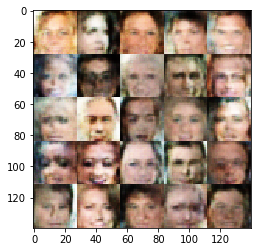

Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.8802
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.5216


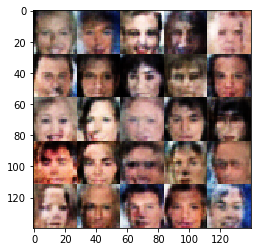

Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 1.7406
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.7470


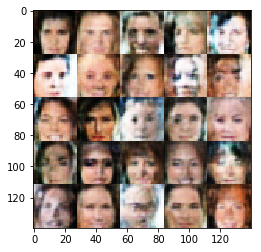

Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.8897


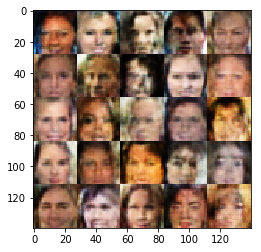

Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8000


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.